In [30]:
# Cell 1: Install MONAI and Other Dependencies
!pip install monai numpy scipy matplotlib scikit-image nibabel




In [31]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import nibabel as nib
import scipy.ndimage as ndi
from scipy.ndimage import uniform_filter, gaussian_filter
from monai.transforms import Transform
from skimage import img_as_float, img_as_uint
from skimage.util import random_noise
from batchgenerators.transforms.abstract_transforms import AbstractTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform

In [32]:
# Load the .nii.gz file for the patient
input_file_path = "C:\\Users\\alelj\\OneDrive\\Desktop\\amsterdam\\AI for medical imaging\\ai4mi_project\\data\\segthor_train\\train\\Patient_01\\Patient_01.nii.gz"

# Load the image using nibabel
real_1 = nib.load(input_file_path)
image_data = real_1.get_fdata()

# Add batch and channel dimensions
image_data = image_data[np.newaxis, np.newaxis, ...]  # Shape: (1, 1, x, y, z)
image_data = image_data.astype(np.float32)

# Define the slice number to visualize
slice_number = 110

In [33]:
def apply_and_visualize_transform(transform, image_data, slice_number, title):
    # Create a deep copy of the image data to prevent in-place modifications
    image_data_copy = copy.deepcopy(image_data)
    # If no transform is provided, use the original image data
    if transform is None:
        augmented_data = {'data': image_data_copy}
    else:
        # Apply the transform
        augmented_data = transform(data=image_data_copy)
    # Extract the augmented image
    augmented_image = augmented_data['data'][0, 0]
    # Visualize the augmented image slice with proper scaling
    plt.imshow(
        augmented_image[:, :, slice_number],
        cmap='gray')
    plt.title(title)
    plt.colorbar(label='HU Value')
    plt.show()

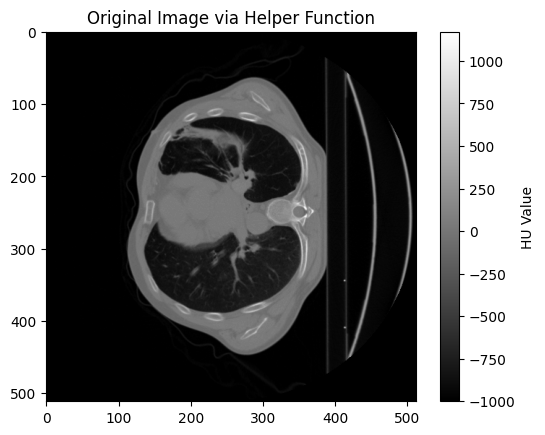

In [34]:
# Apply and visualize the original image using the helper function
apply_and_visualize_transform(None, image_data, slice_number, "Original Image via Helper Function")


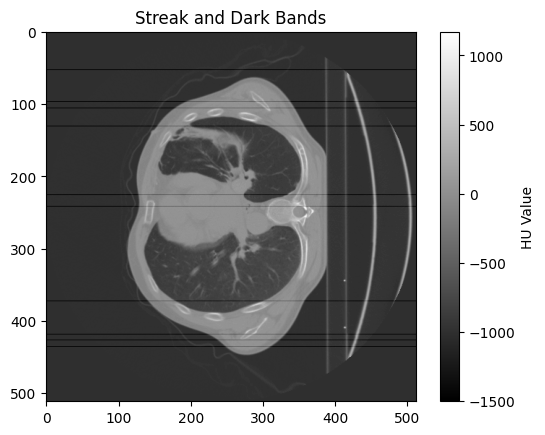

In [47]:
# 1 Darck Bands Artifact (good)
class StreakArtifactTransform(AbstractTransform):
    def __init__(self, num_streaks=10, intensity_decrease=500):
        self.num_streaks = num_streaks
        self.intensity_decrease = intensity_decrease

    def __call__(self, **data_dict):
        data = data_dict['data']
        for _ in range(self.num_streaks):
            x = np.random.randint(0, data.shape[2])
            data[:, :, x, :, :] -= self.intensity_decrease
        data_dict['data'] = data
        return data_dict
# Apply and visualize Streak and Dark Bands
streak_transform = StreakArtifactTransform()
apply_and_visualize_transform(streak_transform, image_data, slice_number, "Streak and Dark Bands")


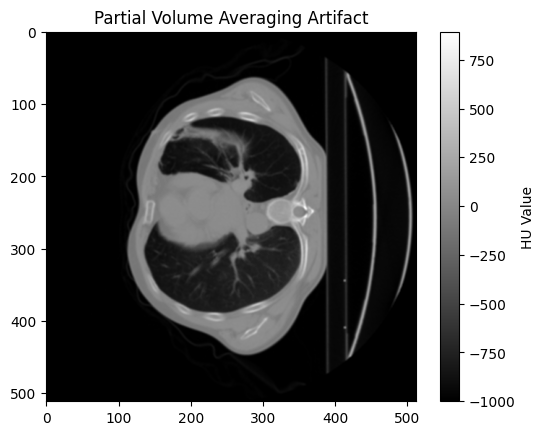

In [113]:
#2 Partial Volume Averaging Artifact (good)
class PartialVolumeArtifactTransform(AbstractTransform):
    def __init__(self, kernel_size_range=(3, 5)):
        # Define a range for the kernel size
        self.kernel_size_range = kernel_size_range

    def __call__(self, **data_dict):
        data = data_dict['data']
        
        # Randomly select a kernel size from the given range
        kernel_size = random.randint(*self.kernel_size_range)

        # Apply uniform filtering using the random kernel size
        data = uniform_filter(data, size=kernel_size, mode='reflect')
        data_dict['data'] = data
        return data_dict

# Apply and visualize Partial Volume Averaging Artifact with random kernel size
partial_volume_transform = PartialVolumeArtifactTransform(kernel_size_range=(3, 5))
apply_and_visualize_transform(partial_volume_transform, image_data, slice_number, "Partial Volume Averaging Artifact")

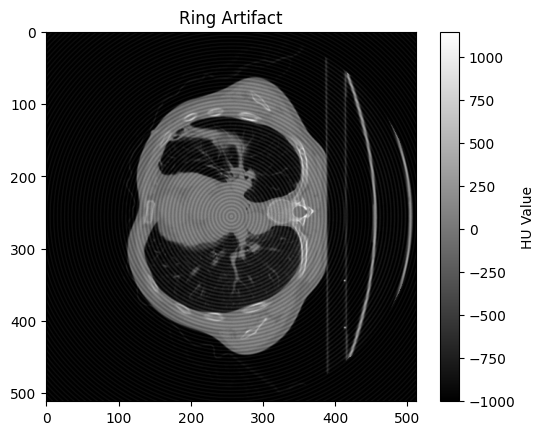

In [55]:
#3 Ring Artifact (good)
class RingArtifactTransform(Transform):
    def __init__(self, frequency_range=(2, 50), amplitude_range=(10, 500)):
        self.frequency = np.random.uniform(*frequency_range)
        self.amplitude = np.random.uniform(*amplitude_range)

    def __call__(self, **data_dict):
        data = data_dict['data']
        rows, cols = data.shape[2], data.shape[3]
        center = (rows / 2, cols / 2)
        y, x = np.indices((rows, cols))
        r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
        ring_pattern = self.amplitude * np.sin(2 * np.pi * r / self.frequency)
        # Expand ring_pattern to match the data shape: (1,1,x,y,z)
        ring_pattern_expanded = ring_pattern[np.newaxis, np.newaxis, :, :, np.newaxis]
        # Add ring pattern across all slices
        data += ring_pattern_expanded
        # Clip to maintain HU range
        data = np.clip(data, -1000, 3000)
        data_dict['data'] = data
        return data_dict

# Apply and visualize Ring Artifact
ring_transform = RingArtifactTransform(frequency_range=(2, 5), amplitude_range=(100, 500))
apply_and_visualize_transform(ring_transform, image_data, slice_number, "Ring Artifact")


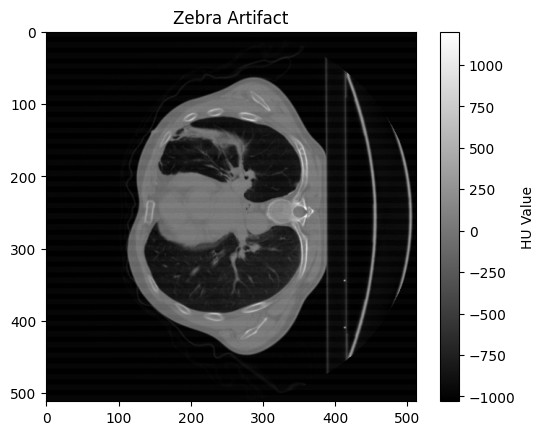

In [105]:
#4 Zebra Artifact 
class ZebraArtifactTransform(AbstractTransform):
    def __init__(self, stripe_frequency_range=(5, 15), amplitude_range=(30, 70)):
        # Instead of fixed values, we now define ranges for stripe frequency and amplitude
        self.stripe_frequency_range = stripe_frequency_range
        self.amplitude_range = amplitude_range

    def __call__(self, **data_dict):
        data = data_dict['data']

        # Randomly choose a stripe frequency and amplitude from the given ranges
        stripe_frequency = random.uniform(*self.stripe_frequency_range)
        amplitude = random.uniform(*self.amplitude_range)

        X = np.arange(data.shape[2])

        # Create the zebra pattern using the randomly chosen stripe frequency and amplitude
        zebra_pattern = (np.sin(2 * np.pi * X / stripe_frequency) > 0).astype(float) * amplitude - (amplitude / 2)
        zebra_pattern = zebra_pattern[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]
        
        # Add the zebra pattern to the data
        data_dict['data'] = data + zebra_pattern
        return data_dict
# Apply and visualize Zebra Artifact
zebra_transform = ZebraArtifactTransform()
apply_and_visualize_transform(zebra_transform, image_data, slice_number, "Zebra Artifact")
